<a href="https://colab.research.google.com/github/stemgene/Computer-Vision-Projects/blob/main/02_imger2vec_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
!pip install timm

In [37]:
from PIL import Image
import torch
from torchvision import models
from torchvision import transforms as T
import timm
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


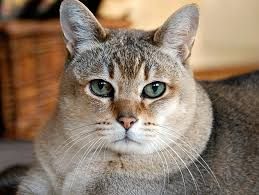

In [38]:
img1 = Image.open("/gdrive/My Drive/Programming/Computer Vision/wudaokou/datasets/cat.jpg")
img1

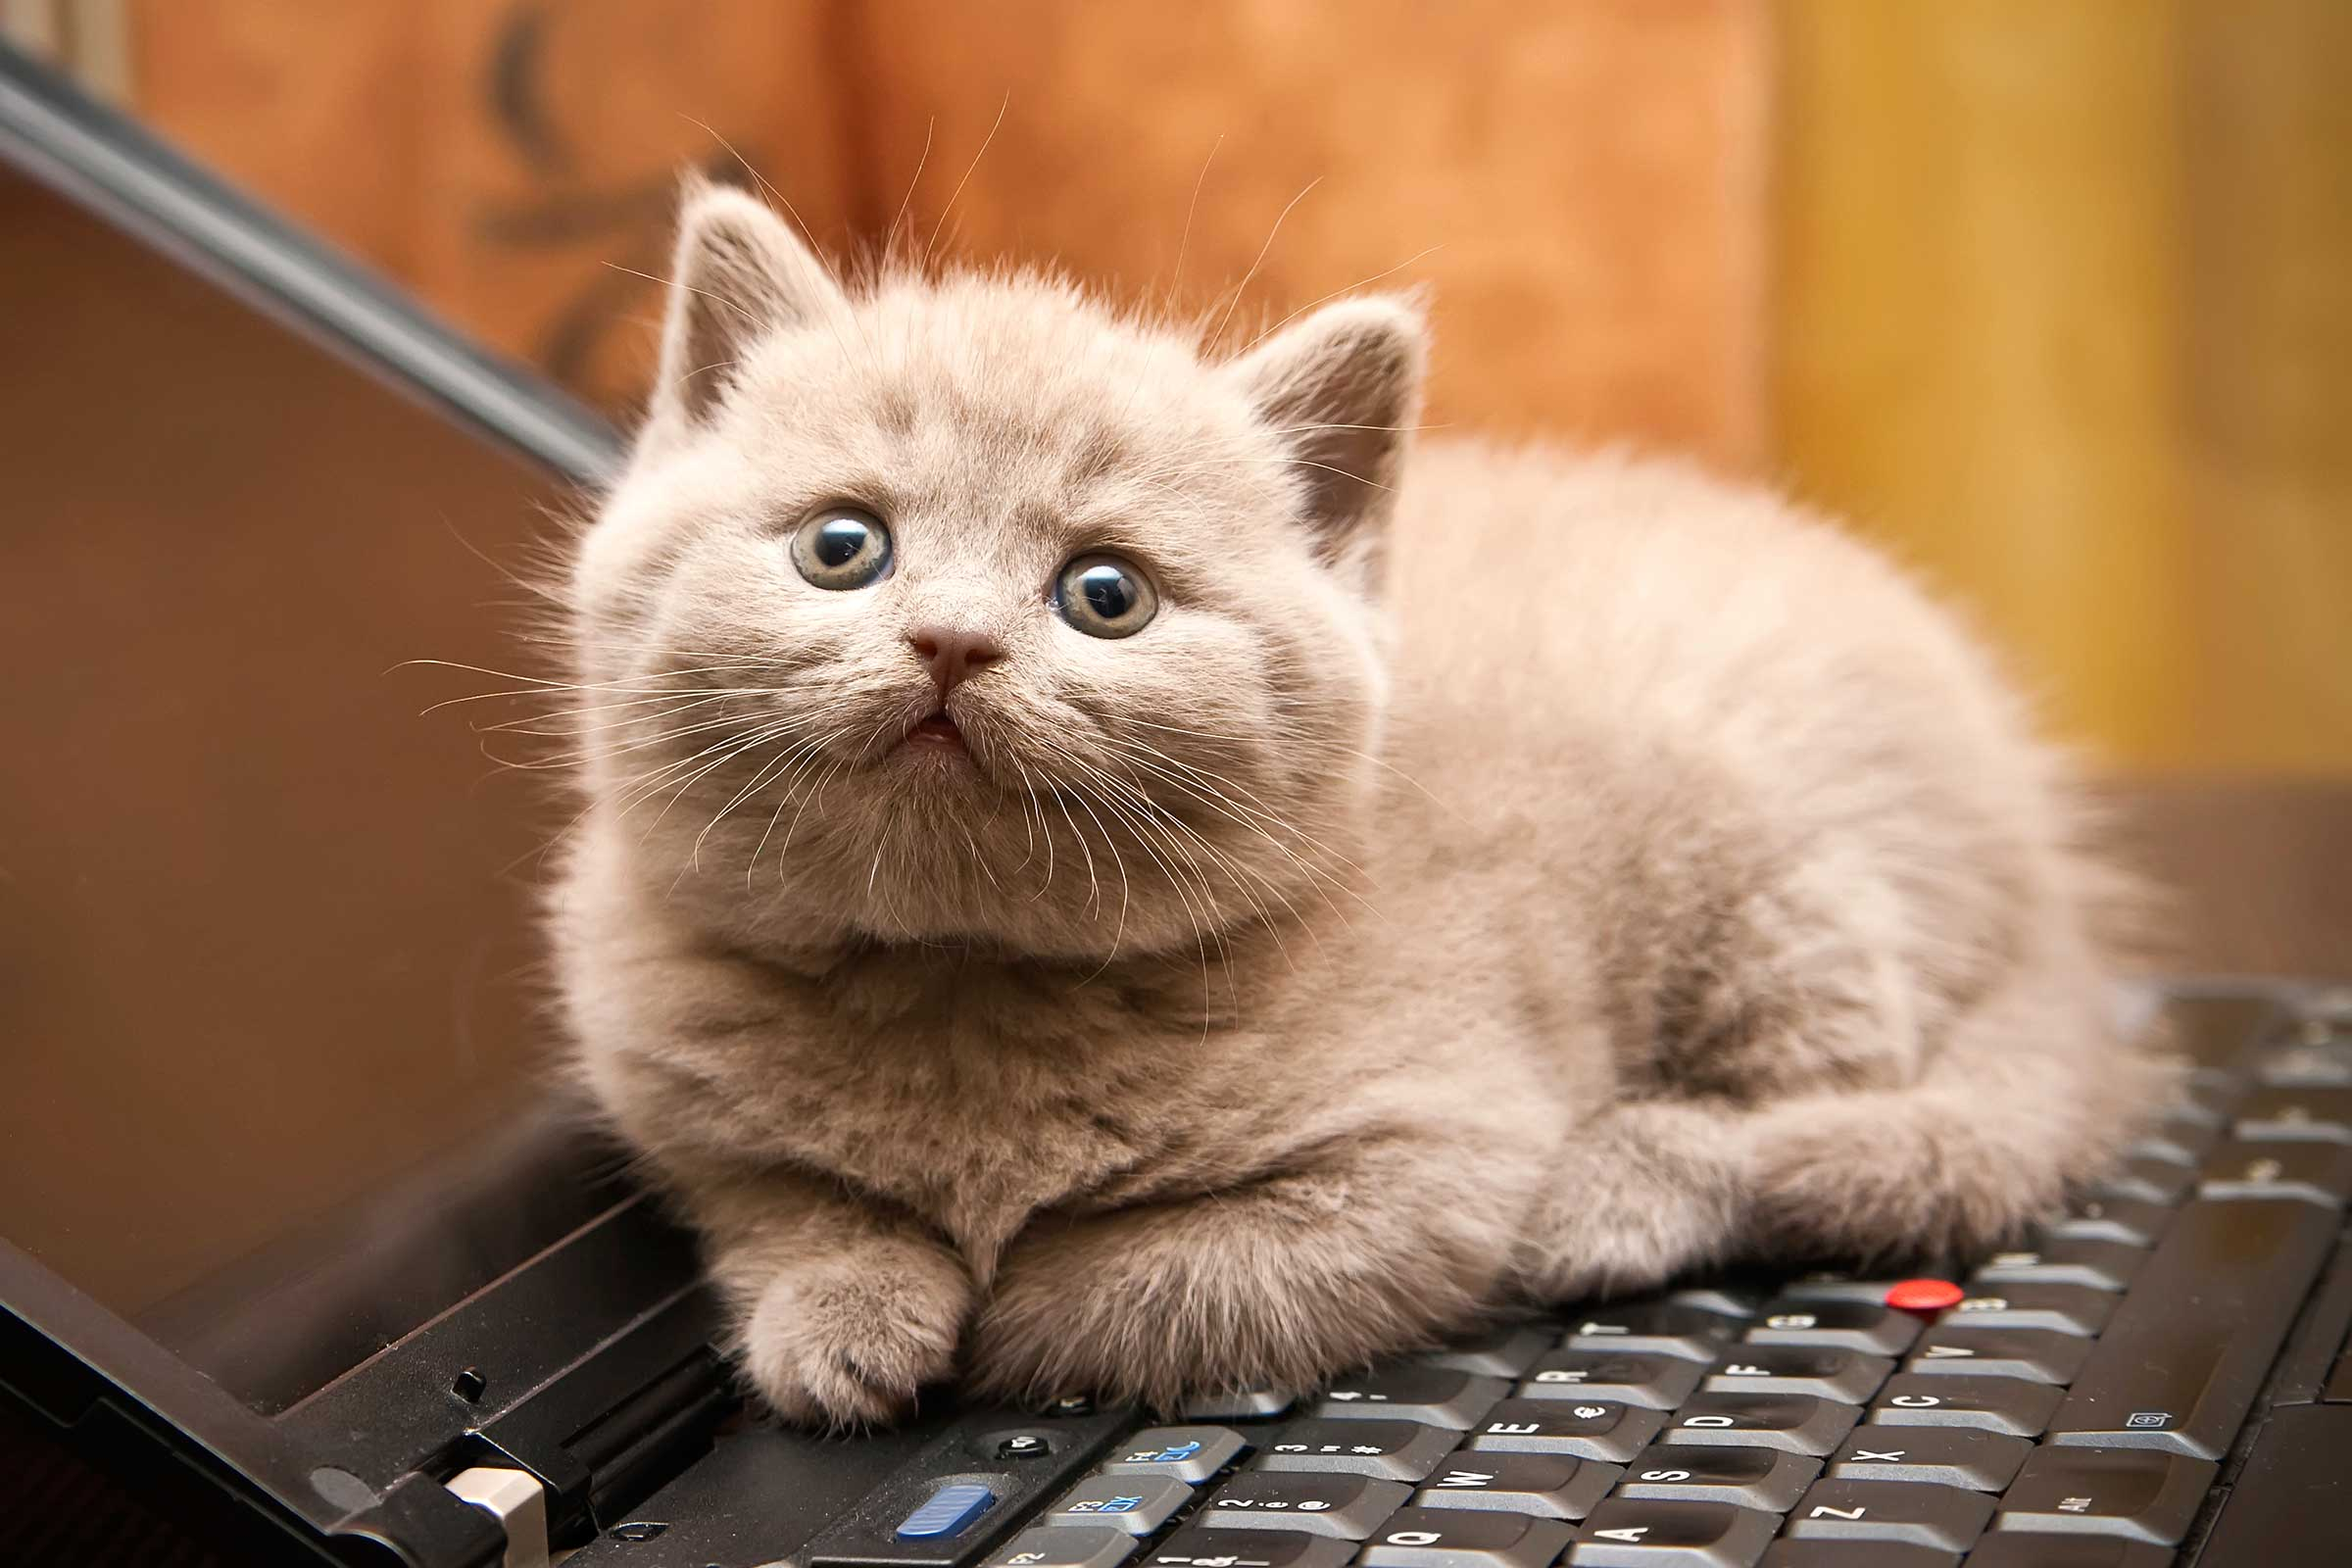

In [39]:
img2 = Image.open("/gdrive/My Drive/Programming/Computer Vision/wudaokou/datasets/cat2.jpg")
img2

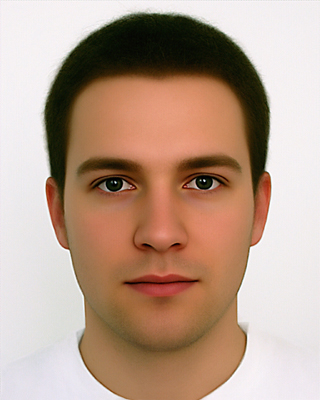

In [40]:
img3 = Image.open("/gdrive/My Drive/Programming/Computer Vision/wudaokou/datasets/face.jpg")
img3

In [41]:
trans = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(mean=timm.data.IMAGENET_DEFAULT_MEAN, std=timm.data.IMAGENET_DEFAULT_STD)
])

In [42]:
t_img1 = trans(img1).unsqueeze(0)
t_img2 = trans(img2).unsqueeze(0)
t_img3 = trans(img3).unsqueeze(0)
t_img2.shape

torch.Size([1, 3, 256, 256])

In [43]:
model = models.resnet152(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

所谓的**特征向量提取**就是通过一系列的卷积网络，直到输入进全连接层之前的一维2048的向量

In [44]:
layer = model._modules['avgpool']
layer

AdaptiveAvgPool2d(output_size=(1, 1))

In [45]:
# model.eval()
# with torch.no_grad():
#     feature_vec = torch.zeros(2048)
#     def copy(model, input, output):
#         print(output.shape)
#         feature_vec.copy_(output.reshape(output.shape[1]))
#         print(feature_vec.shape)
#     h = layer.register_forward_hook(copy)  # 对layer注册前向hook函数，把这个layer的output（2048维）回调copy函数，
#     model(t_img1)
#     h.remove()

In [46]:
feature_vec1, feature_vec2, feature_vec3 = torch.zeros(2048), torch.zeros(2048), torch.zeros(2048)
vec_list = {t_img1: feature_vec1, t_img2: feature_vec2, t_img3: feature_vec3}

model.eval()
with torch.no_grad():
    for img, vec in vec_list.items():
        def copy(m, i, o):
            vec.copy_(o.reshape(o.shape[1]))
        h = layer.register_forward_hook(copy)
        model(img)
        h.remove()

In [47]:
feature_vec1

tensor([0.1450, 0.1259, 0.9560,  ..., 0.5801, 0.0807, 0.2939])

# Similarity

In [49]:
cos_sim = torch.nn.CosineSimilarity(dim=1)

In [50]:
cos_sim(feature_vec1, feature_vec2)

IndexError: ignored

报错原因是输入希望是2维，而当前的feature_vec是[2048]

In [51]:
cos_sim(feature_vec1.unsqueeze(0), feature_vec2.unsqueeze(0))

tensor([0.6934])

两只猫的相似度是0.69

In [52]:
cos_sim(feature_vec1.unsqueeze(0), feature_vec3.unsqueeze(0))

tensor([0.5019])

猫和人脸的相似度稍低

In [53]:
cos_sim(feature_vec3.unsqueeze(0), feature_vec2.unsqueeze(0))

tensor([0.5275])